# mlarena Basic Usage

This notebook demonstrates basic usage of the `mlarena` library for machine learning model development and evaluation. With just a few lines of code, you can build a baseline model that 

* has comprehensive reporting
* with global and local explanation 
* easy deployment with mlflow
* can easily migrate to a different algorithm without disrupting deployment 


In [1]:
# Standard library imports
import multiprocessing
import os
import warnings

# Third party imports
import lightgbm as lgb
import pandas as pd
from sklearn.datasets import (
    fetch_california_housing,
    fetch_openml
)
from sklearn.ensemble import (
    RandomForestClassifier, 
    RandomForestRegressor
)   
from sklearn.model_selection import train_test_split
import mlflow
mlflow.autolog(disable=True)

from mlarena import PreProcessor, ML_PIPELINE

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)

# Classification Demo

In [2]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X = PreProcessor.mlflow_input_prep(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
preprocessor = PreProcessor()
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

## Fit and Use the Fitted Model

You can fit and score with mlpipeline model like you would with an sklearn model. And `evaluate` methods offer comprehensive reports including below metrics and visuals.


| Category | Classification | Regression |
|----------|---------------|------------|
| Metrics | - AUC<br>- F1 Score <br>- Fbeta (if beta specified)<br>- Precision <br>- Recall<br> | - RMSE (Root Mean Squared Error)<br>- NRMSE (Normalized RMSE as % of target mean)<br>- MAPE (Mean Absolute Percentage Error)<br>- R² Score (including adjusted R²)<br>- Improvement over baseline (%) |
| Plots | - ROC_AUC curve<br>- Precision-recall curve | - Residual analysis (residuals vs predicted values)<br>- Prediction error plot (actual vs predicted with error bands) |

<br>



Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.805
F1:        0.765
Precision: 0.838
Recall:    0.703
Log Loss:  0.464
Pos Rate:  0.378

AUC (threshold independent):
AUC:   0.876


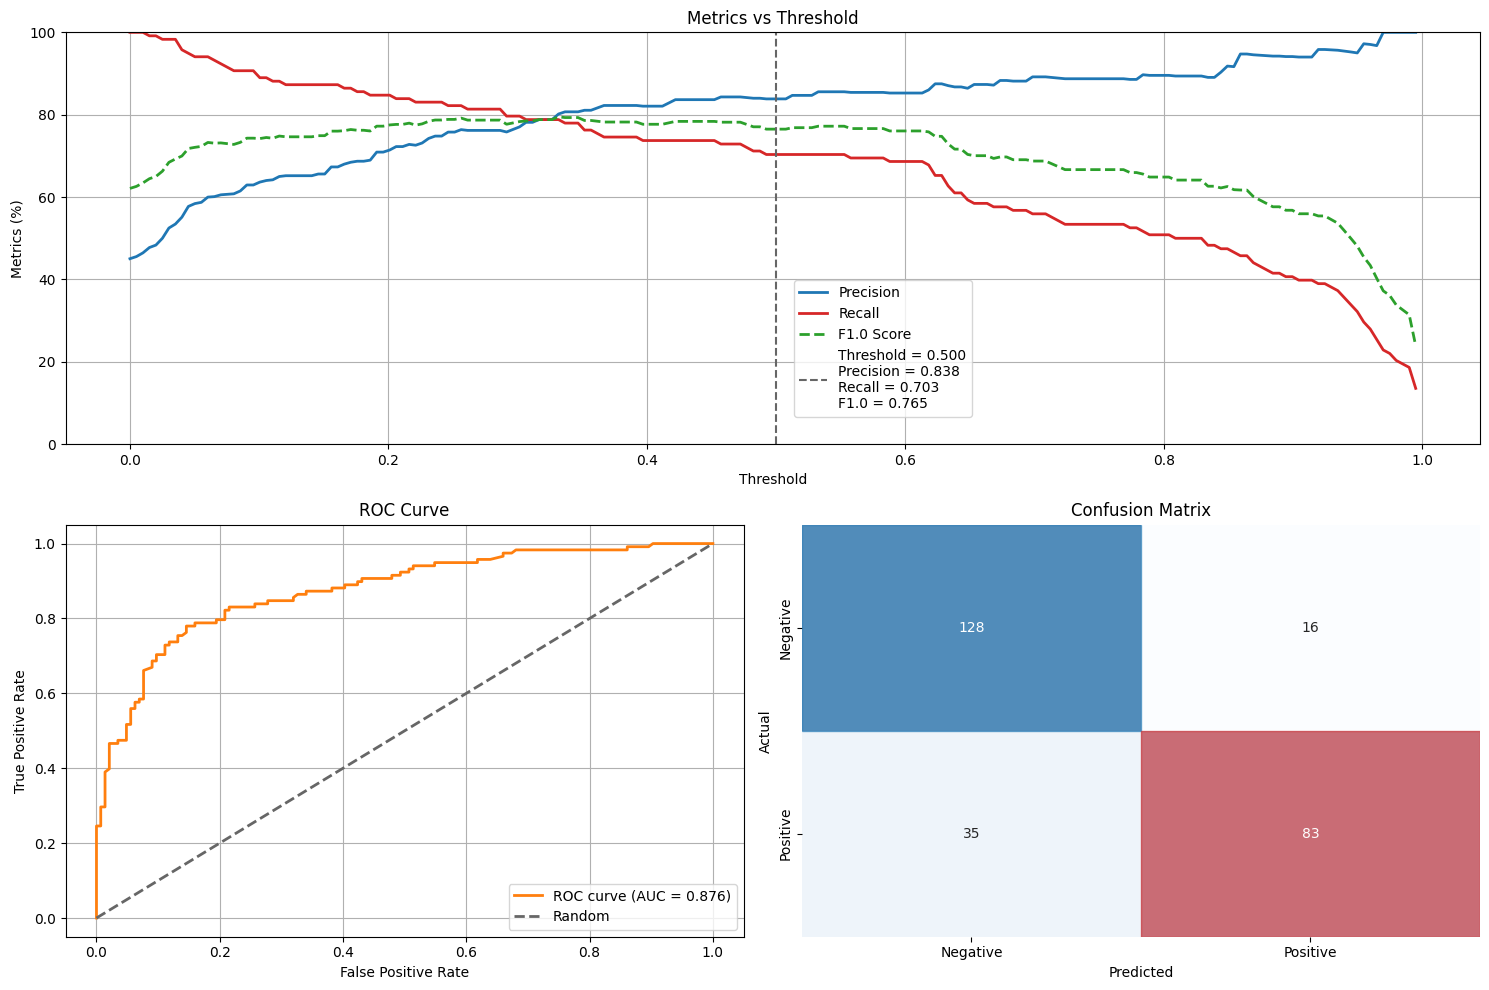

In [4]:
# define pipeline
mlpipeline = ML_PIPELINE(
    model = lgb.LGBMClassifier(verbose=-1),
    preprocessor = PreProcessor()
    )
# fit pipeline
mlpipeline.fit(X_train,y_train)
# make prediction
y_pred = mlpipeline.predict(context = None, model_input = X_test)

# evaluate pipeline with metrics and visualization
results =mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)

## Model Explanation

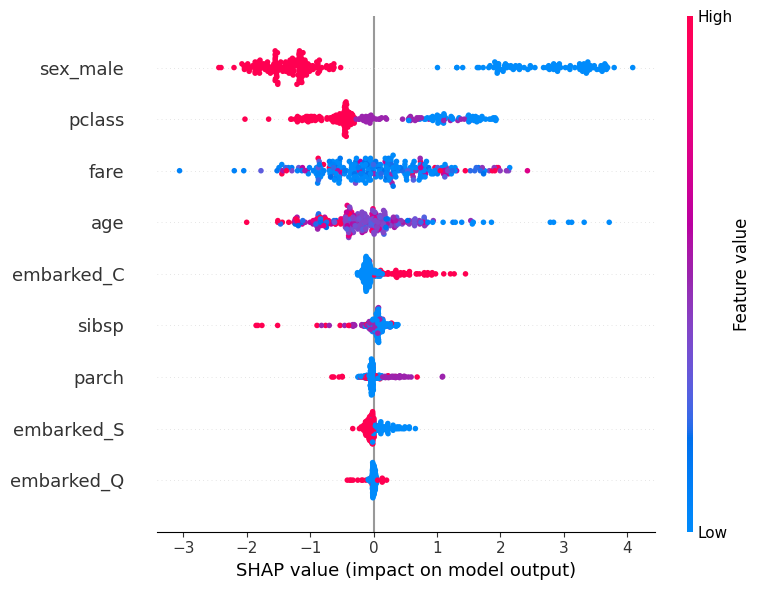

In [5]:
mlpipeline.explain_model(X_test)

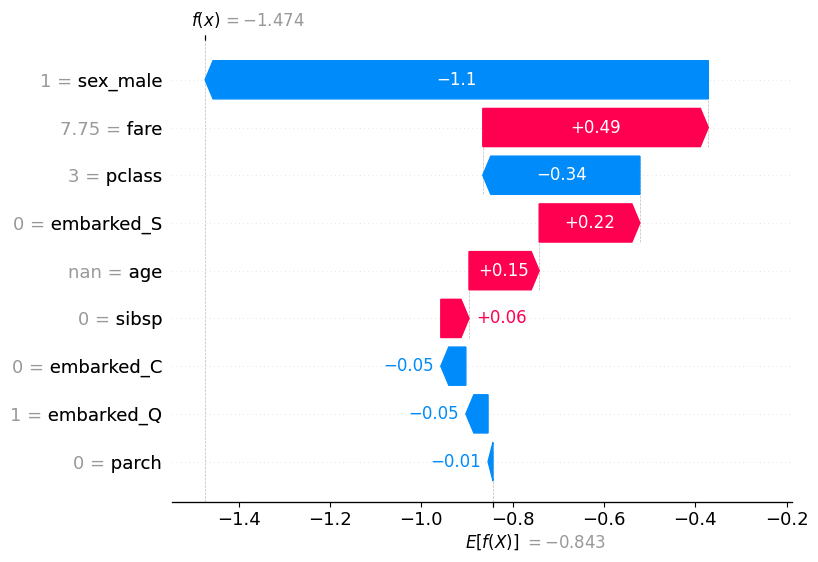

In [6]:
mlpipeline.explain_case(5)


## Swap Algorithm

Classification Metrics Report

Evaluation Parameters:
Threshold: 0.500
Beta:      1.000

Metrics:
Accuracy:  0.798
F1:        0.760
Precision: 0.816
Recall:    0.712
Log Loss:  0.858
Pos Rate:  0.393

AUC (threshold independent):
AUC:   0.862


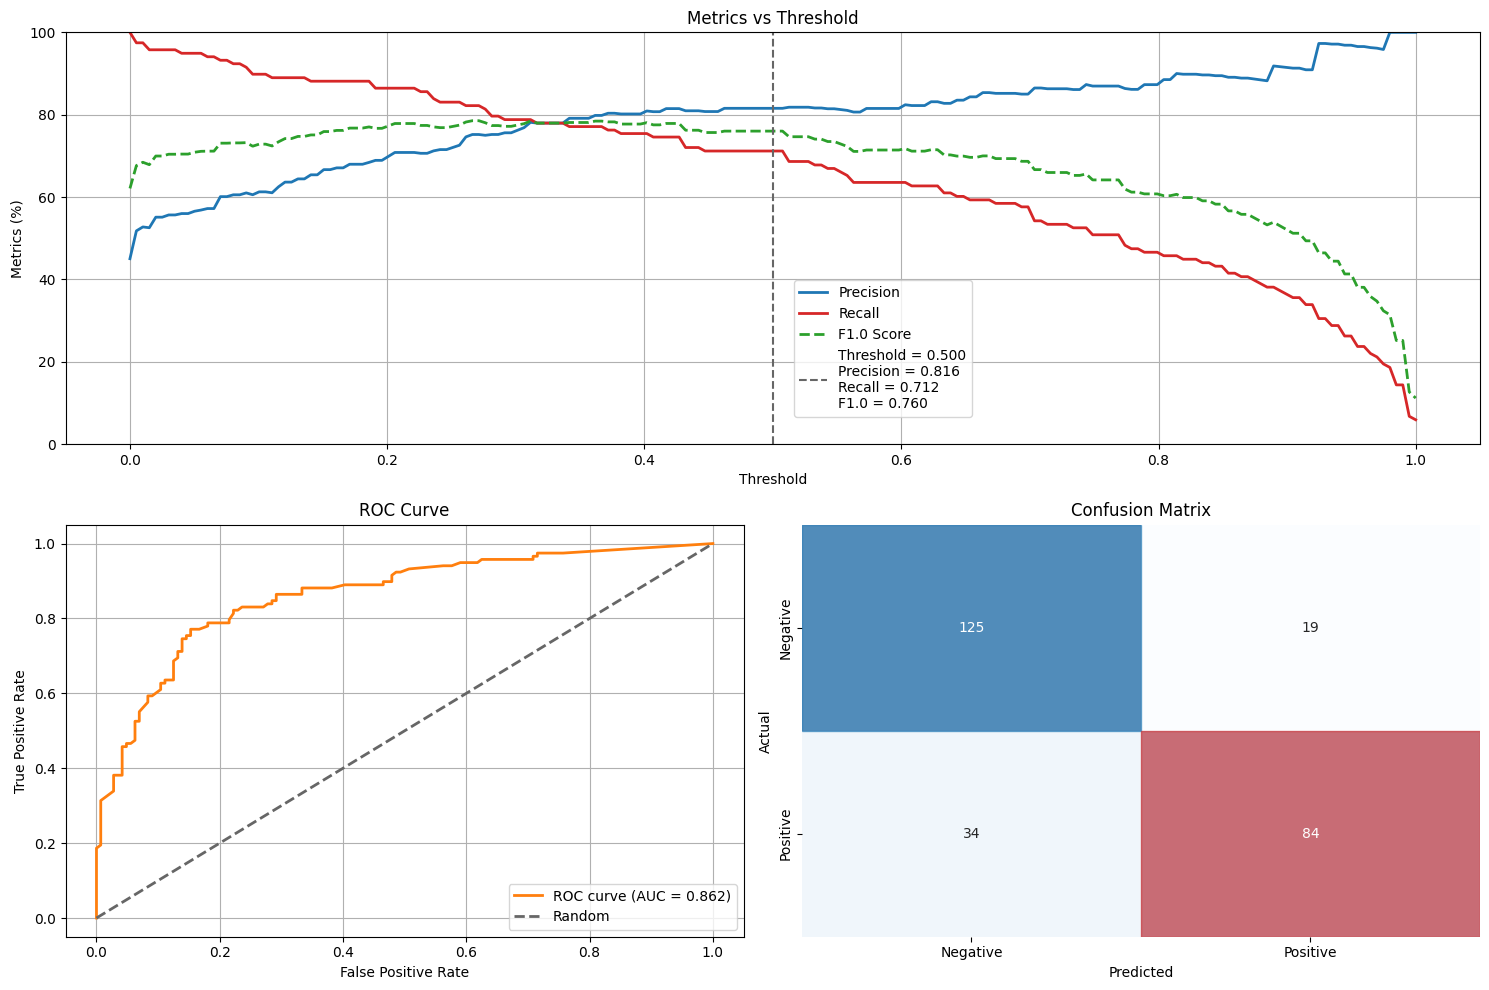

In [7]:
mlpipeline_rf = ML_PIPELINE(
    model = RandomForestClassifier(),
    preprocessor = PreProcessor()
)
mlpipeline_rf.fit(X_train,y_train)
rf_results = mlpipeline_rf.evaluate(X_test,y_test, verbose=True, visualize=True)


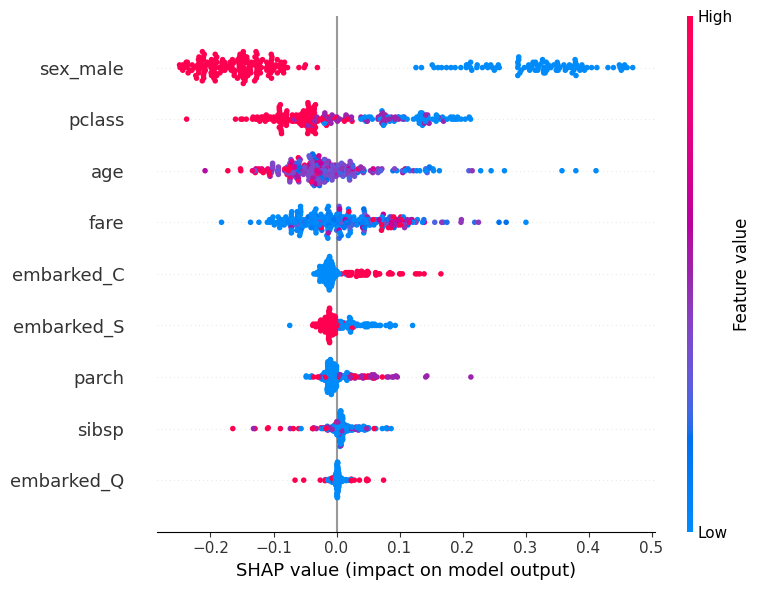

In [8]:
mlpipeline_rf.explain_model(X_test)


# Regression Demo

In [9]:
# Load data
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
X = PreProcessor.mlflow_input_prep(X)

y = california.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Fit and Use the Fitted Model

Regression Model Evaluation:
RMSE: 0.507
MAE: 0.329
Median AE: 0.200
R² Score: 0.804
Adjusted R² Score: 0.803

Normalized RMSE Variants:
- NRMSE (mean): 24.7%
- NRMSE (std): 44.3%
- NRMSE (IQR): 35.3%

Percentage Errors:
- MAPE: 19.0% (excluding zeros)
- SMAPE: 16.6%

RMSE Improvements over Baselines:
- vs Mean: 55.7%
- vs Median: 56.9%


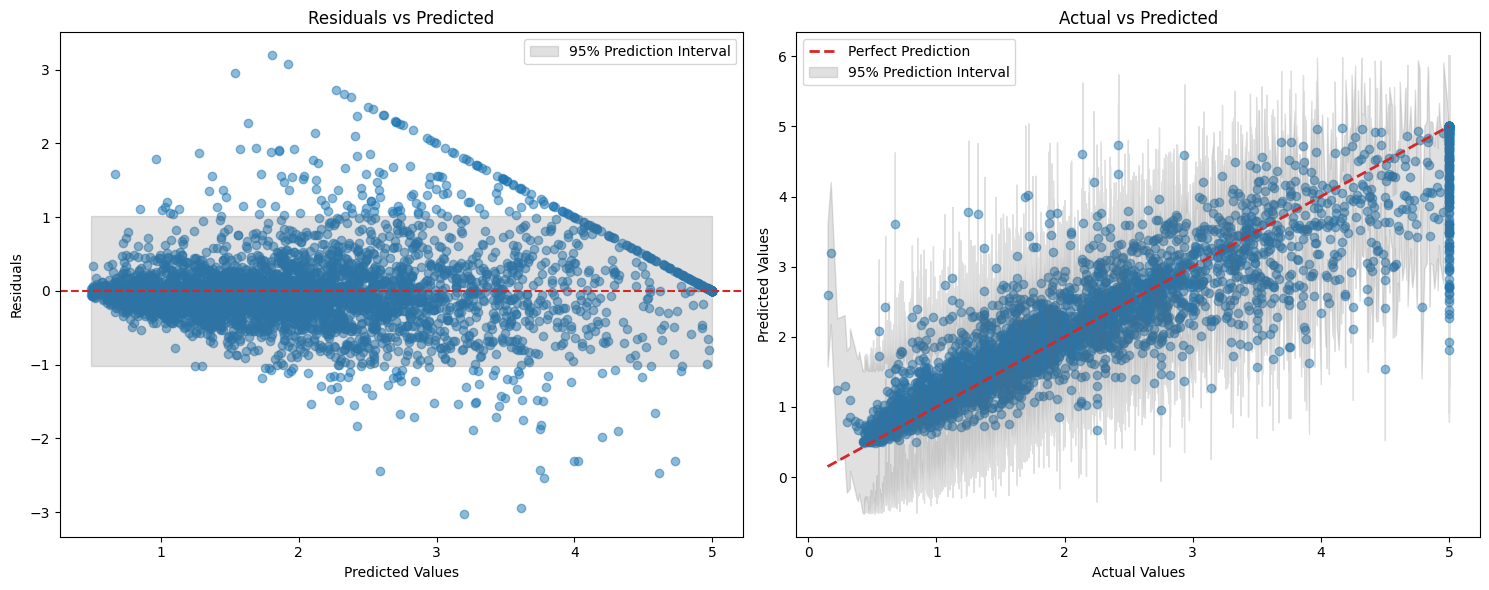

In [10]:
mlpipeline = ML_PIPELINE(
    model = RandomForestRegressor(),
    preprocessor = PreProcessor()
)
mlpipeline.fit(X_train,y_train)
results = mlpipeline.evaluate(X_test,y_test, verbose=True, visualize=True)


## Swap Algorithm

In [11]:
mlpipeline_lgb = ML_PIPELINE(
    model = lgb.LGBMRegressor(),
    preprocessor = PreProcessor()
)
mlpipeline_lgb.fit(X_train,y_train)

Regression Model Evaluation:
RMSE: 0.460
MAE: 0.305
Median AE: 0.200
R² Score: 0.839
Adjusted R² Score: 0.838

Normalized RMSE Variants:
- NRMSE (mean): 22.4%
- NRMSE (std): 40.2%
- NRMSE (IQR): 32.0%

Percentage Errors:
- MAPE: 17.7% (excluding zeros)
- SMAPE: 15.9%

RMSE Improvements over Baselines:
- vs Mean: 59.8%
- vs Median: 60.9%


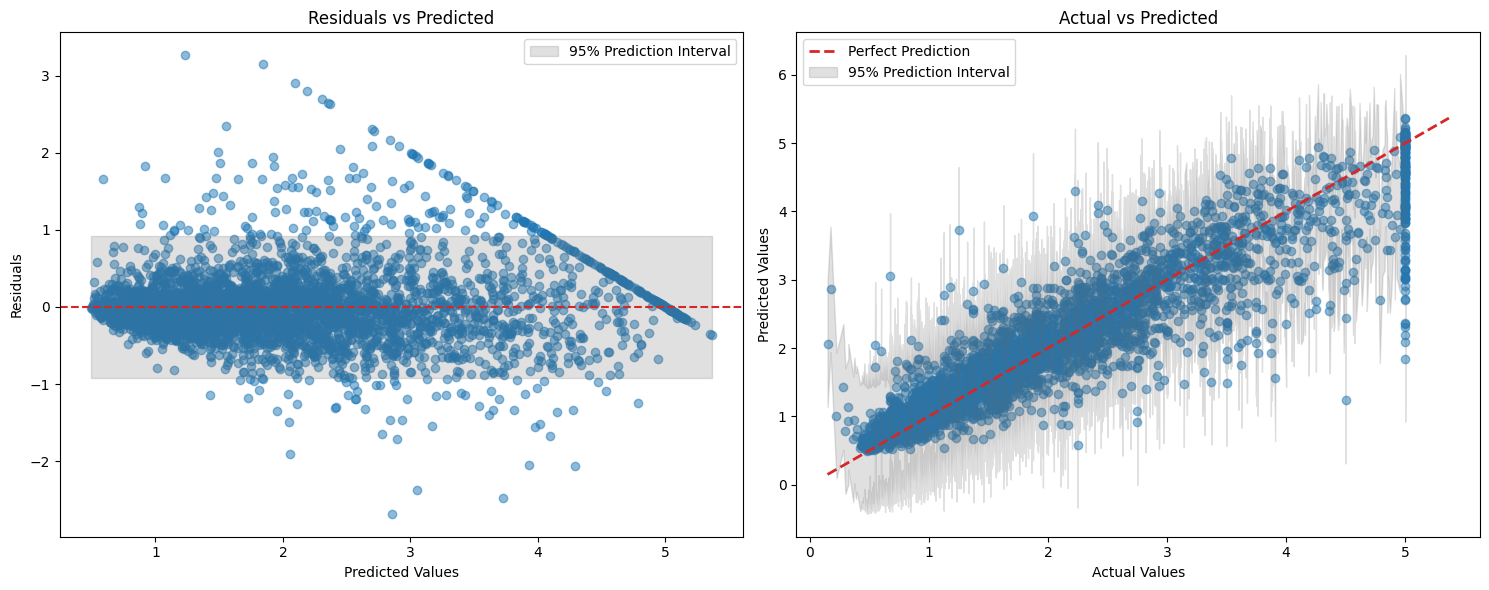

In [12]:
results = mlpipeline_lgb.evaluate(X_test,y_test, verbose=True, visualize=True)

# Log and Use the Logged Model

In [13]:
# Log the model to MLflow
# The warning about "mlarena not found in the public PyPI package index" is expected
# This happens because MLflow checks package availability against its cached PyPI index
# Since mlarena is a newer package (v0.1.9 released in April 2025), MLflow's index (last updated March 2025) doesn't recognize it yet
results = mlpipeline_lgb.evaluate(X_test, y_test, verbose=False, visualize=False, log_model=True)
model_info = results['model_info']

2025/05/08 19:11:00 INFO mlflow.pyfunc: Validating input example against model signature


## Load and Utilize the Logged Model

The loaded model can be used to score new data, and has all the abilities of an ML_PIPELINE instance. For example, it can produce comprehensive reporting and model explanation with a one-liner as demoed below. 

In [14]:
print(model_info.utc_time_created)
print(model_info.run_id)
print(model_info.model_uri)
print(model_info.mlflow_version)

2025-05-08 09:11:00.748004
62a839c893aa41f7bfa3d41db6ab3697
runs:/62a839c893aa41f7bfa3d41db6ab3697/ml_pipeline
2.22.0


Regression Model Evaluation:
RMSE: 0.460
MAE: 0.305
Median AE: 0.200
R² Score: 0.839
Adjusted R² Score: 0.838

Normalized RMSE Variants:
- NRMSE (mean): 22.4%
- NRMSE (std): 40.2%
- NRMSE (IQR): 32.0%

Percentage Errors:
- MAPE: 17.7% (excluding zeros)
- SMAPE: 15.9%

RMSE Improvements over Baselines:
- vs Mean: 59.8%
- vs Median: 60.9%


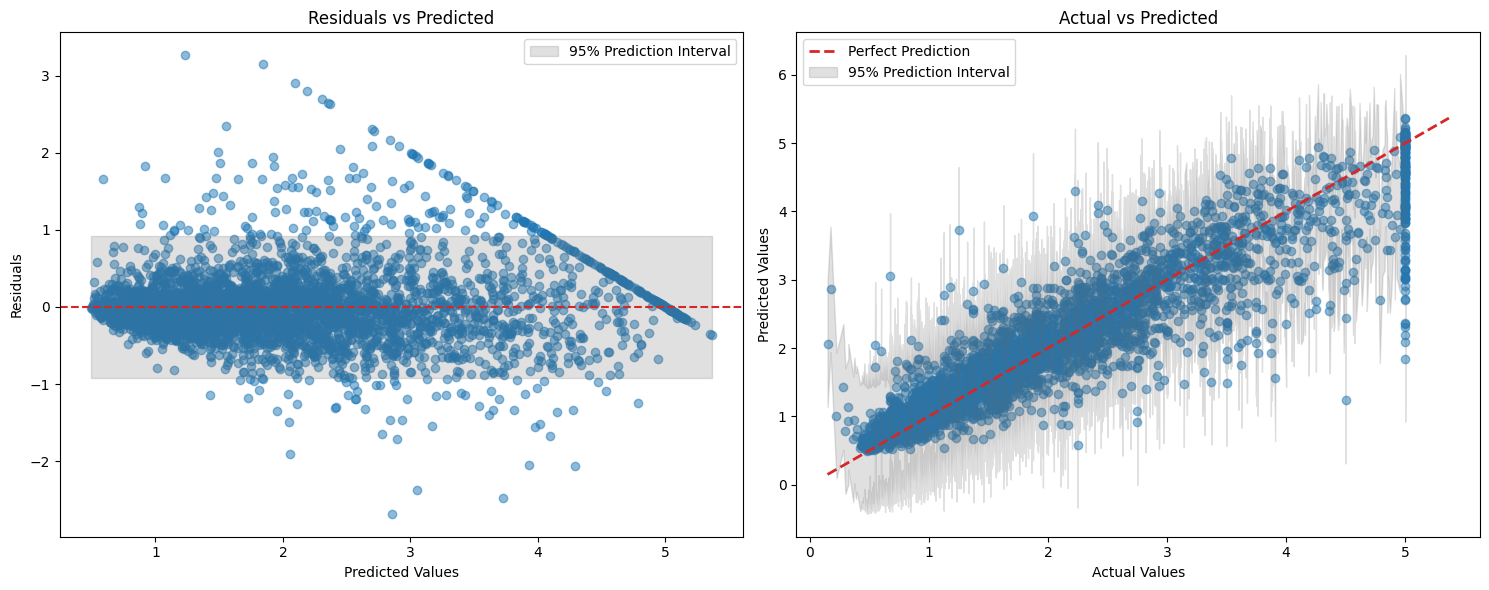

{'rmse': np.float64(0.45987687653485965),
 'mae': 0.3054582064419925,
 'median_ae': np.float64(0.1997964726465257),
 'nrmse_mean': np.float64(22.378403100492093),
 'nrmse_std': np.float64(40.173358745021844),
 'nrmse_iqr': np.float64(31.99699958496154),
 'mape': np.float64(17.71173699773407),
 'smape': np.float64(15.941806115483526),
 'r2': 0.8386101247143777,
 'adj_r2': 0.8382966702345804,
 'rmse_improvement_over_mean': np.float64(59.82664125497816),
 'rmse_improvement_over_median': np.float64(60.888132863709565)}

In [15]:
loaded_model = mlflow.pyfunc.load_model(model_uri=model_info.model_uri) 
unwrapped_model = loaded_model.unwrap_python_model()
unwrapped_model.evaluate(X_test, y_test, verbose=True, visualize=True)

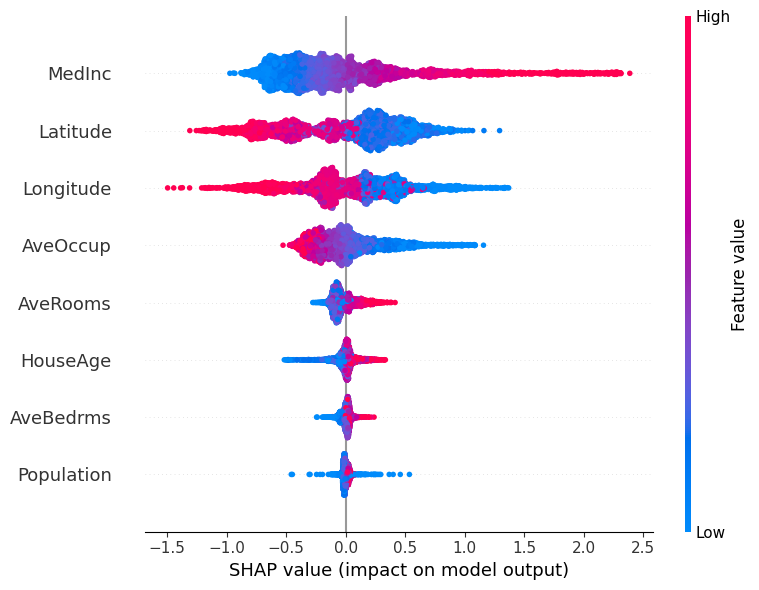

In [16]:
unwrapped_model.explain_model(X_test)

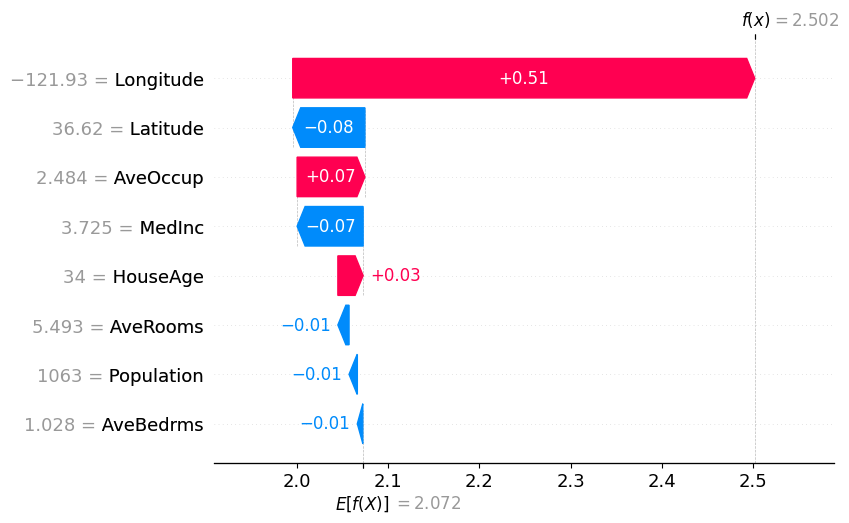

In [17]:
unwrapped_model.explain_case(5)

In [18]:
# call the trained preprocessor as the ml_pipeline attribute
X_test_transformed = unwrapped_model.preprocessor.transform(X_test)
X_test_transformed.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
20046,-1.155085,-0.286324,-0.520686,-0.171746,-0.030301,0.067408,0.195100,0.285347
3024,-0.708659,0.110435,-0.165815,0.223472,0.121851,-0.036030,-0.235491,0.060975
15663,-0.210402,1.856173,-0.610765,0.205892,-0.102419,-0.149989,1.009478,-1.424870
20484,0.975113,-0.921138,0.305115,-0.176552,0.244979,0.030011,-0.637999,0.429943
9814,-0.081794,0.427842,0.024193,-0.158465,-0.319653,-0.052971,0.457199,-1.170581


In [19]:
# prediction with loaded model directly
X_test_prepped = PreProcessor.mlflow_input_prep(X_test)
loaded_model.predict(pd.DataFrame(X_test_prepped.head()))

array([0.58559011, 0.8555311 , 4.70605075, 2.33467468, 2.50219885])